<a href="https://colab.research.google.com/github/hegdenischay/NEURONNet/blob/main/Automation/Complete_Network_Transfer_Entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
size = 5
dimension = "High" #do I even need this lol
epochs =  20
A_plus = 0.01 
A_minus = -0.0011
lateralDelay = 5
currentAmp = 0.1

# Install Neuron

In [2]:
pip install pandas neuron copent

     |████████████████████████████████| 15.0 MB 5.4 MB/s 


In [3]:
import time
totalstart = time.time()
import os
if os.getcwd() != "/content":
    # we are not in google colab, assume hebbian library is in current dir
    from hebb import ORN, MCELL, GCELL
else:
    # download from git
    import shutil, requests
    url = 'https://cloud.operationtulip.com/s/t8nbn8Y582w94P3/download/git.zip'
    response = requests.get(url, stream=True)
    with open('git.zip', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    import zipfile
    with zipfile.ZipFile('git.zip', 'r') as zip_ref:
        zip_ref.extractall('')


In [4]:
!nrnivmodl &>/dev/null

In [5]:
from neuron import h #.h is a HOC object instance & gui from neuron can also be imported 
from math import pi                  
from neuron.units import ms,mV
from hebb_test import ORN, MCELL, GCELL
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
pc = h.ParallelContext()
import random  
import matplotlib.pyplot as plt1

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()

import seaborn as sns

In [6]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [7]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    # print(source, dest)
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [8]:
def latConMaker(source, dest, weights, delay, threshold, type='exc'):
    if type == 'exc':
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendexcisyn, sec=source.dend)
    else:
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendinhisyn, sec=source.dend)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [9]:
%matplotlib inline
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(300 * ms)

    f = plt1.figure(figsize=(16,9))
    ax = f.add_subplot(1,1,1)
    ax.plot(t, list(cell_axon), label=name+' axon '+addendum)
    ax.plot(t, list(cell_dend), label=name+' dendrite '+addendum)
    ax.legend(loc="upper right")
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('v (mV)')
    plt1.show()

In [10]:
import math
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [11]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [12]:
class AON:
    def __init__(self,M,weights,delay1=1,delay2=2,delay3=3,delay4=4):
        wMM=weights[0]
        wMG=weights[1]
        wGM=weights[2]
        wGG=weights[3]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 5

        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.G1=GCELL(3,self.M)
        self.G2=GCELL(4,self.M)
        self.cells = [self.M1, self.M2, self.G1, self.G2]
        
        self.nc0 = netConMaker(self.M1, self.M2, wMM, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to E2
        self.nc1 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to E1
        self.nc2 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to I1
        self.nc3 = netConMaker(self.G1, self.M2, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E2
        self.nc4 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to I2
        self.nc5 = netConMaker(self.G2, self.G1, wGG, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to I1
        self.nc6 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to E1
        self.nc7 = netConMaker(self.M1, self.G2, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I2
        self.nc8 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I1
        self.nc9 = netConMaker(self.G1, self.M1, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E1

In [13]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=0,delay2=2,delay3=4,delay4=6):
        wMM=weights[0]
        wMG=weights[1]
        wGM=weights[2]
        wGG=weights[3]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 5
        
        #Making 2 neurons
        self.orn = ORN(1,self.M)
        self.P1=MCELL(2,self.M)
        self.P2=MCELL(3,self.M)
        self.cells = [self.orn, self.P1, self.P2]
        
        #Giving current pulse
        self.stim = h.IClamp(self.orn.dend(0.5))  #P1.soma to P1.dend
        # self.stimArr = [h.IClamp(self.orn.ciliumArr[i](0.5)) for i in range(len(self.orn.ciliumArr))]
        self.stim.delay = 10
        self.stim.dur = 100
        self.stim.amp = currentAmp
        
        self.nc0 = netConMaker(self.orn, self.P1, wMM, self.maindelay+delay2, self.th, 'soma') #Connecting ORN to P1
        self.nc1 = netConMaker(self.P1, self.P2, wMM, self.maindelay+delay3, self.th, 'soma') #Connecting P1 to P2
        self.nc2 = netConMaker(self.P2, self.P1, wMM, self.maindelay+delay3, self.th, 'soma') #Connecting P2 to P1
    
        # 4-coupled

        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.G1=GCELL(3,self.M)
        self.G2=GCELL(4,self.M)
        self.cells.extend([self.M1, self.M2, self.G1, self.G2])

        self.nc14 = netConMaker(self.orn, self.M1, wMM, delay1+self.maindelay, self.th, 'soma')
        self.nc3 = netConMaker(self.P1, self.M1, wMM, delay1+self.maindelay, self.th, 'soma')
        self.nc4 = netConMaker(self.M1, self.M2, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting M1 to M2
        self.nc5 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting M2 to M1
        self.nc6 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th, 'soma') #Connecting M2 to G1
        self.nc7 = netConMaker(self.G1, self.M2, wGM, delay2+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to M2
        self.nc8 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to G2
        self.nc9 = netConMaker(self.G2, self.G1, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting G2 to G1
        self.nc10 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting G2 to M1
        self.nc11 = netConMaker(self.M1, self.G2, wMG, delay4+self.maindelay, self.th, 'soma') #Connecting M1 to G2
        self.nc12 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting M1 to G1
        self.nc13 = netConMaker(self.G1, self.M1, wGM, delay1+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to M1

In [14]:

class LATERAL:
    """Laterally coupling N-2 coupled neurons
    """
    def __init__(self,N,weights,delay1=0,delay2=2,delay3=4,delay4=6):
        wMML=weights[1]
        wGGL=weights[5]
        
        self.N = N
        self.th = -70
        self.maindelay = lateralDelay
        self.sets = [CONNECTING(i, weights) for i in range(N)]
            
        self.twoCupArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(latConMaker(self.sets[r].P1, self.sets[r+1].P1,wMML,self.maindelay+delay2,self.th)) #P1[0] to P1[1]
          netConList.append(latConMaker(self.sets[r+1].P1, self.sets[r].P1, wMML, self.maindelay+delay2,self.th))

          self.twoCupArr.append(netConList)
        self.fourCupArr = []
        for r in range(1,N-1):
            for j in range(N-r):
                netConList = []
                netConList.append(latConMaker(self.sets[j].M1, self.sets[j+r].M1, wMML, self.maindelay+delay3, self.th)) #Connect M1[0] to M1[1]
                netConList.append(latConMaker(self.sets[j+r].M1, self.sets[j].M1, wMML, self.maindelay+delay3, self.th)) #Connect M1[1] to M1[0]
                netConList.append(latConMaker(self.sets[j].G1, self.sets[j+r].G1, wGGL, self.maindelay+delay2, self.th, 'inh')) #Connecting G1[0] to G1[1]
                netConList.append(latConMaker(self.sets[j+r].G1, self.sets[j].G1, wGGL, self.maindelay+delay2, self.th, 'inh')) #Connecting G1[1] to G1[0]
                self.fourCupArr.append(netConList)

        # add AON and PC
        self.AON = AON(5,weights)
        self.PC = AON(6,weights)
        self.DPC = GCELL(7,self.N)
        # add noise to AON's M1
        self.stim = h.IClamp(self.AON.M1.dend(0.5))  #P1.soma to P1.dend
        self.noise = np.random.normal(0, 0.1, 100)
        self.input = h.Vector(self.noise)
        self.tv = h.Vector([i for i in range(100)])
        self.input.play(self.stim._ref_amp, self.tv, True)
        self.otherNetCons = []
        self.otherNetCons.append(netConMaker(self.sets[0].M1, self.AON.M1, wMML, self.maindelay+delay2, self.th, 'soma')) # 4-coupled M1 -> AON's E1
        for i in self.sets:
            for j in self.sets:
                if i != j:
                    self.otherNetCons.append(netConMaker(i.P1, j.P1, wMML, self.maindelay+delay2, self.th, 'soma')) # all-to-all in P1
                    self.otherNetCons.append(netConMaker(i.M1, j.M1, wMML, self.maindelay+delay3, self.th, 'soma')) # all-to-all in M1
                    self.otherNetCons.append(netConMaker(i.G1, j.G1, wGGL, self.maindelay+delay2, self.th, 'soma')) # all-to-all in M1

        for i in self.sets:
            self.otherNetCons.append(netConMaker(self.AON.M1, i.P2, wMML, self.maindelay+delay2, self.th, 'soma')) # AON E1 -> 2-coupled P2
        if dimension == "High":
            self.otherNetCons.append(netConMaker(self.PC.M1, self.AON.G1, wMML, self.maindelay+delay3+10, self.th, 'soma')) # PC's A1 to AON's I1
        self.otherNetCons.append(netConMaker(self.sets[0].M1, self.PC.M1, wMML, self.maindelay+delay2, self.th, 'soma')) # M1 to A1
        for i in self.sets:
            self.otherNetCons.append(netConMaker(self.AON.M1, i.G1, wMML, self.maindelay+delay2, self.th, 'soma')) # AON's E1 -> 4-coupled G1
        
        self.otherNetCons.append(netConMaker(self.PC.G1, self.DPC, wMML/100000, self.maindelay+delay3, self.th, 'soma', 'inh')) # PC's B1 -> DPC
        self.otherNetCons.append(netConMaker(self.DPC, self.PC.G1, wMML/100000, self.maindelay+delay3, self.th, 'soma')) # DPC -> PC's B1
        if dimension == "High":
            for i in self.sets:
                self.otherNetCons.append(netConMaker(self.DPC, i.G1, wMML/100000, self.maindelay+delay3+10, self.th))# DPC to G1 
        self.otherNetCons.append(netConMaker(self.sets[-1].G1, self.DPC, wMML, self.maindelay+4, self.th, 'soma'))
        


In [15]:
#Give N value to get N no. of 2 coupled neurons laterally connected
#given_input_from_user = int(input('Enter the number of 2 coupled sets required: '))
import numpy as np
# size = 5
low, high = 1, 5
weights = np.random.uniform(low, high, 2*size-1)
# all_weights = np.random.uniform(low, high,2*given_input_from_user-1)
# all_weights = [4.65058555, 2.92840154, 3.68134116, 1.30487304, 1.07771946, 3.15136447, 1.04247865, 2.29878494, 2.01195344]
# all_weights = [0.95336892, 0.87793015, 0.71060386, 0.88298338, 0.84561174, 0.5006465, 0.60983793, 0.88890724, 0.85189888]
L1=LATERAL(size,weights)

In [16]:
def learn():
    import sys, time
    tick = time.time()
    weight_data = []

    out = display(progress(0, epochs), display_id=True)

    for l in range(epochs):
        #print("iteration no is",l)
        out.update(progress(l, epochs))    
        # print("\nmutual learning")
        P1_axon_data = []
        P1_dend_data = []
        P2_axon_data = []
        P2_dend_data = []
        M1_axon_data = []
        M1_dend_data = []
        M2_axon_data = []
        M2_dend_data = []
        G1_axon_data = []
        G1_dend_data = []
        G2_axon_data = []
        G2_dend_data = []
        P1_spike_times = []
        P2_spike_times = []
        M1_spike_times = []
        M2_spike_times = []
        G1_spike_times = []
        G2_spike_times = []

        h.finitialize(-70* mV)
        h.continuerun(300*ms)
        t = h.Vector().record(h._ref_t)
        
        for i in range(len(L1.sets)):
            P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
            P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
            P1_spike_times.append(list(L1.sets[i].P1.spike_times))
            P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
            P2_spike_times.append(list(L1.sets[i].P2.spike_times))
            P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
            M1_axon_data.append(list(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v)))
            M1_dend_data.append(list(h.Vector().record(L1.sets[i].M1.dend(0.5)._ref_v)))
            M1_spike_times.append(list(L1.sets[i].M1.spike_times))
            M2_axon_data.append(list(h.Vector().record(L1.sets[i].M2.axon(0.5)._ref_v)))
            M2_dend_data.append(list(h.Vector().record(L1.sets[i].M2.dend(0.5)._ref_v)))
            M2_spike_times.append(list(L1.sets[i].M2.spike_times))
            G1_axon_data.append(list(h.Vector().record(L1.sets[i].G1.axon(0.5)._ref_v)))
            G1_dend_data.append(list(h.Vector().record(L1.sets[i].G1.dend(0.5)._ref_v)))
            G1_spike_times.append(list(L1.sets[i].G1.spike_times))
            G2_axon_data.append(list(h.Vector().record(L1.sets[i].G2.axon(0.5)._ref_v)))
            G2_dend_data.append(list(h.Vector().record(L1.sets[i].G2.dend(0.5)._ref_v)))
            G2_spike_times.append(list(L1.sets[i].G2.spike_times))

    
        # h.finitialize(-70 * mV)

        for i in range(len(L1.sets)):
            # 2-coupled STDP-based learning
            L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
            # logging
            # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
            L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
            L1.sets[i].nc3.weight[0] += generate_L_weight_delta(P1_spike_times[i], M1_spike_times[i])
            # 4-coupled STDP-based learning
            L1.sets[i].nc4.weight[0] += generate_L_weight_delta(M1_spike_times[i], M2_spike_times[i])
            L1.sets[i].nc5.weight[0] += generate_L_weight_delta(M2_spike_times[i], M1_spike_times[i])
            L1.sets[i].nc6.weight[0] += generate_L_weight_delta(M2_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc7.weight[0] += generate_L_weight_delta(G1_spike_times[i], M2_spike_times[i])
            L1.sets[i].nc8.weight[0] += generate_L_weight_delta(G1_spike_times[i], G2_spike_times[i])
            L1.sets[i].nc9.weight[0] += generate_L_weight_delta(G2_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc10.weight[0] += generate_L_weight_delta(G2_spike_times[i], M1_spike_times[i])
            L1.sets[i].nc11.weight[0] += generate_L_weight_delta(M1_spike_times[i], G2_spike_times[i])
            L1.sets[i].nc12.weight[0] += generate_L_weight_delta(M1_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc13.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
            # L1.sets[i].DPC.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
            
        # do a proper logging function
        weight_data.append(L1.sets[0].nc1.weight[0])


        #Lateral Learning
        for i in range(len(L1.sets)-1):
            # 2-coupled part
            L1.twoCupArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
            L1.twoCupArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
            # 4-coupled part
            L1.fourCupArr[i][0].weight[0] += generate_L_weight_delta(M1_spike_times[i], M1_spike_times[i+1])
            L1.fourCupArr[i][1].weight[0] += generate_L_weight_delta(M1_spike_times[i+1], M1_spike_times[i])
            L1.fourCupArr[i][2].weight[0] += generate_L_weight_delta(G1_spike_times[i], G1_spike_times[i+1])
            L1.fourCupArr[i][3].weight[0] += generate_L_weight_delta(G1_spike_times[i+1], G1_spike_times[i])
        # plotCell(L1.sets[-1].M1, 'M1')


    out.update(progress(epochs, epochs))    
    tock = time.time()
    print("The time it took to learn", tock-tick, "seconds")

# Transfer Entropy while changing weights

In [25]:
from copent import transent
# import the threading module
from multiprocessing import Process

M1Arr = []
M2Arr = []
 
def f(resList, arg1, arg2):
    resList.append(transent(list(arg1)[::5], list(arg2)[::5],2))

for M1weight in np.arange(0.1, 2, 0.1):
    L1 = LATERAL(size,weights)
    for i in range(len(L1.sets)):
        L1.sets[0].nc4.weight[0] = M1weight
    learn()
    M1Voltage = h.Vector().record(L1.sets[0].M1.axon(0.5)._ref_v)
    M2Voltage = h.Vector().record(L1.sets[0].M2.axon(0.5)._ref_v)
    h.finitialize(-70*mV)
    h.continuerun(300*ms)
    p = Process(target=f, args=(M1Arr, M1Voltage, M2Voltage))
    p2 = Process(target=f, args=(M2Arr, M2Voltage, M1Voltage))
    p.start()
    p2.start()
    p.join()
    p2.join()
    print("Done")

The time it took to learn 17.672762632369995 seconds
Done


The time it took to learn 17.46719789505005 seconds
Done


The time it took to learn 18.029804706573486 seconds
Done


The time it took to learn 17.433545112609863 seconds
Done


The time it took to learn 17.426042556762695 seconds
Done


The time it took to learn 17.232606410980225 seconds
Done


The time it took to learn 17.378404140472412 seconds
Done


The time it took to learn 17.365339517593384 seconds
Done


The time it took to learn 17.593634128570557 seconds
Done


The time it took to learn 17.46972632408142 seconds
Done


The time it took to learn 17.389776468276978 seconds
Done


The time it took to learn 17.325650215148926 seconds
Done


The time it took to learn 17.3345365524292 seconds
Done


The time it took to learn 17.863111972808838 seconds
Done


The time it took to learn 17.342390060424805 seconds
Done


The time it took to learn 17.29667091369629 seconds
Done


The time it took to learn 17.572621822357178 seconds
Done


The time it took to learn 16.56292486190796 seconds
Done


The time it took to learn 17.414703130722046 seconds
Done


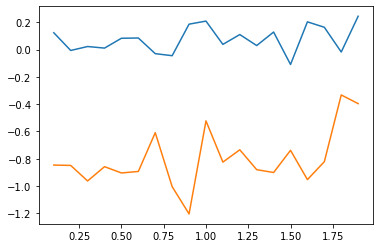

In [24]:
from matplotlib import pyplot as plt
plt.plot(np.arange(0.1,2,0.1),M1Arr)
plt.plot(np.arange(0.1,2,0.1),M2Arr)